In [136]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import seaborn as sns
from scipy.special import expit
from sklearn.metrics import confusion_matrix

In [157]:
def abrirImagenesEscaladas( carpeta, escala=256):
    # abre todas las imagenes de la carpeta, y las escala de tal forma que midan (escala x escala)px
    # devuelve las imagenes aplanadas -> vectores de tamano escala^2 con valores entre 0 y 1
    imagenes = []

    for dirpath, dirnames, filenames in os.walk(carpeta):
        for file in filenames:
            img = Image.open( os.path.join(carpeta, file) )
            img = img.resize((escala, escala))
            img.convert('1')
            img = np.asarray(img)
            if len(img.shape)==3:
                img = img[:,:,0].reshape((escala**2 )) / 255
            else:
                img = img.reshape((escala**2 )) / 255
            
            imagenes.append( img )

    return imagenes

In [158]:
def balancear_datos(imagenes_entrenamiento):
    imagenes_entrenamiento_balanceadas = abrirImagenesEscaladas(imagenes_entrenamiento)
    return imagenes_entrenamiento_balanceadas

In [159]:
imagenes_sanos = np.array(balancear_datos("train_mini2/normal")) #len = 665
imagenes_neum = np.array(balancear_datos("train_mini2/neumonia")) #len =665

# imagenes_sanos = np.array(balancear_datos("train_mini3/normal")) #len = 665
# imagenes_neum = np.array(balancear_datos("train_mini3/pneum")) #len =665


x_test_sanos = np.array(balancear_datos("test/NORMAL"))
x_test_neum = np.array(balancear_datos("test/PNEUMONIA"))

In [140]:
print(len(imagenes_sanos), len(imagenes_neum))

665 665


In [164]:
# Definir el número de iteraciones y la tasa de aprendizaje
MAX_ITER = 1000
TOLERANCIA = 0.0001

In [142]:
def f(x,w,b):
    return (np.tanh(np.dot(x,w)+b)+1)/2

In [143]:
def L(x,d,w,b):
    y_p = f(x,w,b)
    return (y_p-d)**2

<h3>Ejercicio 1</h3>
Gradiente w: sum((tanh(w*i_i+b)+12-d_i)(1-(tanh(w*i_i+b))**2)*i_i)<br>

Gradiente b: sum((tanh(w*i_i+b)+12-d_i)(1-(tanh(w*i_i+b))**2))

Sumatoria realizada dentro del descenso por gradiente

In [144]:
# Derivadas de L(w, b)
def dW(x,d,w,b):
    y_p = f(x,w,b)
    return (y_p-d)*(1-np.tanh(np.dot(x,w)+b)**2) * x

def dB(x,d,w,b):
    y_p = f(x,w,b)
    return (y_p-d)*(1-np.tanh(np.dot(x,w)+b)**2)

<h3>Ejercicio 2</h3>

In [145]:
# Función de búsqueda de parámetros con los cuales se minimiza L(w, b)
def gradiente_descendente(x_sanos,x_enfermos, alpha, x_test_sanos, x_test_enfermos):
    #se agregan los dos ultimos parametros para poder ir calculando para realizar el ejercicio 3

    # Valores iniciales de w y b
    w_t = np.zeros(x_sanos.shape[1]) # cada imagen de x_sanos y x_enfermos con la misma cantidad de columnas
    b_t = 0

    #arrays para almacenar datos utilizados en el punto 3
    errores_totales_train = []
    errores_promedios_train = []
    errores_totales_test = []
    errores_promedios_test=[]

    # Mientras no hayamos llegado al maximo de iteraciones
    iter = 0
    error_anterior = float('inf')

    while iter <= MAX_ITER:
        # Computamos siguientes w y b a partir de las derivadas de la función
        grad_w = 0
        grad_b = 0

        error_test = 0
        error_train = 0 #es el que se quiere minimizar

        
        d_sanos=0 #diagnostico para el conjunto de imagenes sin neumonía
        for i in range(len(x_sanos)):  
            grad_w += dW(x_sanos[i],d_sanos,w_t,b_t)
            grad_b += dB(x_sanos[i],d_sanos,w_t,b_t)
            error_train += L(x_sanos[i],d_sanos,w_t,b_t)
        
        d_neum=1 #diagnostico para el conjunto de imagenes con neumonía
        for i in range(len(x_enfermos)):
            grad_w += dW(x_enfermos[i],d_neum,w_t,b_t)
            grad_b += dB(x_enfermos[i],d_neum,w_t,b_t)
            error_train+=L(x_enfermos[i],d_neum,w_t,b_t)

        errores_totales_train.append(error_train)

        #error con el conjunto de test a partir de w y b actuales
        for j in range(len(x_test_sanos)):
            error_test += L(x_test_sanos[j], 0, w_t, b_t)
        for j in range(len(x_test_enfermos)):
            error_test += L(x_test_enfermos[j], 1, w_t, b_t)
        errores_totales_test.append(error_test)


        #se toma promedio para optimizar la copmplejidad y estabilizar el algoritmo, siendo que la dirección no cambia al ser multiplicada por un escalar
        grad_w /= (len(x_sanos) + len(x_enfermos))
        grad_b /= (len(x_sanos) + len(x_enfermos))
        error_train/=(len(x_sanos) + len(x_enfermos)) #se toma error promedio ya que es una equivalencia que permite hacer la convergencia más rápido y a la vez ser representativa de las diferencias absolutas entre errores cuadráticos totales
        error_test/=(len(x_test_sanos)+len(x_test_enfermos))
        
        
        errores_promedios_train.append(error_train)
        errores_promedios_test.append(error_test)
        
        print(f'iteracion: {iter}, error: {error_train}')

        w_tsig = w_t - alpha * grad_w
        b_tsig = b_t - alpha * grad_b

        # Chequeamos si ya alcanzamos la convergencia
        if abs(error_anterior - error_train) < TOLERANCIA:
            break

        # Preparamos la siguiente iteración
        w_t = w_tsig
        b_t = b_tsig
        error_anterior = error_train
        iter = iter + 1

    return w_t, b_t, errores_promedios_train, errores_totales_train, errores_promedios_test, errores_totales_test

In [165]:
#0.001 el learning rate encontrado que mejor ajusta a escala 256 
w, b, errores_train_pr, errores_train_tot, errores_test_pr, errores_test_tot = gradiente_descendente(imagenes_sanos, imagenes_neum, 0.001, x_test_sanos, x_test_neum)

iteracion: 0, error: 0.25
iteracion: 1, error: 0.239399531289551
iteracion: 2, error: 0.39755886077296454
iteracion: 3, error: 0.45407415686199365
iteracion: 4, error: 0.24497134669085122
iteracion: 5, error: 0.4911264916830652
iteracion: 6, error: 0.48460045073375324
iteracion: 7, error: 0.46093946039810496
iteracion: 8, error: 0.2597497151545883
iteracion: 9, error: 0.49553822503282896
iteracion: 10, error: 0.4945194834484825
iteracion: 11, error: 0.49292152885278806
iteracion: 12, error: 0.4901030381253121
iteracion: 13, error: 0.48407746368880245
iteracion: 14, error: 0.46557924311218024
iteracion: 15, error: 0.3419549254549279
iteracion: 16, error: 0.49145098697534184
iteracion: 17, error: 0.4854586256584203
iteracion: 18, error: 0.4648484698262402
iteracion: 19, error: 0.29536267128808175
iteracion: 20, error: 0.496301021905533
iteracion: 21, error: 0.4956271013799205
iteracion: 22, error: 0.4946584466210623
iteracion: 23, error: 0.4931585489079309
iteracion: 24, error: 0.4905654

<h3>Ejercicio 3: Error Cuadrático</h3>
Con descenso del gradiente en el ejercicio 2 se obtuvo tanto la evolución de tanto el error cuadrático como el error cuadrático promedio para el conjunto de entrenamiento y el conjunto de test.<br>
Se realizan las visualizaciones con las variables de errores retornadas por el descenso de gradiente.

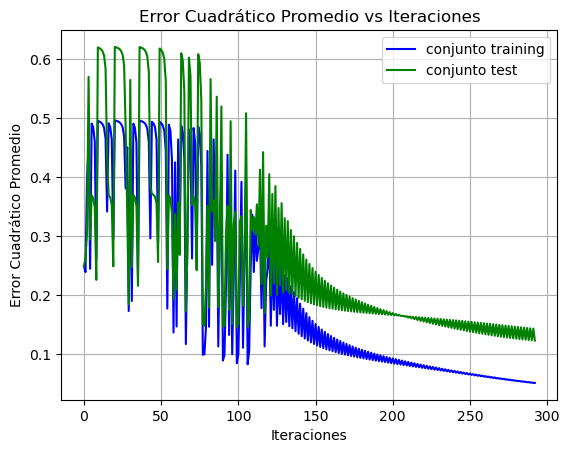

In [147]:
plt.plot(range(len(errores_train_pr)), errores_train_pr, color='blue', label='conjunto training')
plt.plot(range(len(errores_test_pr)), errores_test_pr, color="green", label='conjunto test')
plt.plot()
plt.xlabel('Iteraciones')
plt.ylabel('Error Cuadrático Promedio')
plt.title('Error Cuadrático Promedio vs Iteraciones')
plt.grid()
plt.legend()
plt.show()

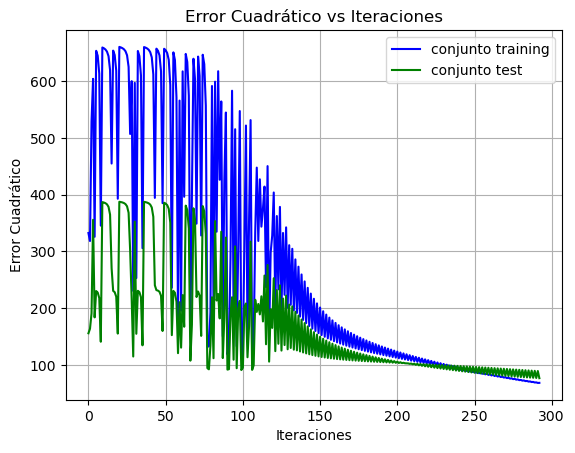

In [148]:
plt.plot(range(len(errores_train_tot)), errores_train_tot, color='blue', label='conjunto training')
plt.plot(range(len(errores_test_tot)), errores_test_tot, color="green", label='conjunto test')
# plt.scatter(len(errores),error_cuadratico_promedio, color="red",label = "error conjunto test")
plt.plot()
plt.xlabel('Iteraciones')
plt.ylabel('Error Cuadrático')
plt.title('Error Cuadrático vs Iteraciones')
plt.grid()
plt.legend()
plt.show()

<h3>Ejercicio 4</h3>
Para la optimización realizada anteriormente se fueron explorando varios valores de alpha hasta llegar a uno que minimizó el error cuadrático promedio. Se explora a continuación la convergencia con diferentes valores que fueron evaluados.

In [149]:
alphas = [0.01, 0.005, 0.002, 0.001, 0.0005, 0.0001] #valores utilizados al principio para identificar un rango
alphas = [0.0018, 0.0015, 0.0012, 0.001, 0.0008, 0.0007, 0.0005]

errores_iteraciones_test = []
errores_convergencia_test = []

for i in range(len(alphas)):
    w_prueba,b_prueba,err_train_pr, err_train_tot, err_test_pr, err_test_tot = gradiente_descendente(imagenes_sanos, imagenes_neum, alphas[i], x_test_sanos, x_test_neum)
    errores_iteraciones_test.append(err_test_pr)
    errores_convergencia_test.append(err_test_pr[-1])


iteracion: 0, error: 0.25
iteracion: 1, error: 0.24107670934839237
iteracion: 2, error: 0.49925323302777885
iteracion: 3, error: 0.49918890644867553
iteracion: 0, error: 0.25
iteracion: 1, error: 0.23944238134366516
iteracion: 2, error: 0.4932654314940007
iteracion: 3, error: 0.4873512821363388
iteracion: 4, error: 0.4599280450071324
iteracion: 5, error: 0.21182065159450086
iteracion: 6, error: 0.48632843017746674
iteracion: 7, error: 0.4528647863404553
iteracion: 8, error: 0.2473932038684598
iteracion: 9, error: 0.4998963072599869
iteracion: 10, error: 0.4998953529866506
iteracion: 0, error: 0.25
iteracion: 1, error: 0.2390000689731045
iteracion: 2, error: 0.45840385271178136
iteracion: 3, error: 0.21484153233754374
iteracion: 4, error: 0.36240910868348103
iteracion: 5, error: 0.4954960300495908
iteracion: 6, error: 0.49368312775821294
iteracion: 7, error: 0.4898584342764083
iteracion: 8, error: 0.4784947667647217
iteracion: 9, error: 0.40550713399915944
iteracion: 10, error: 0.464666

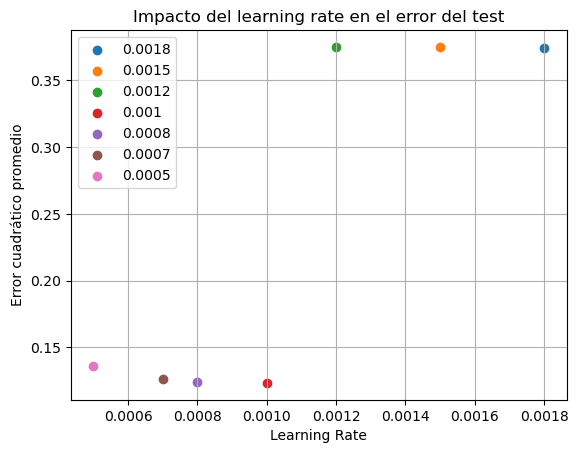

In [150]:
for i in range(len(alphas)):
    alfa = alphas[i]
    plt.scatter(alfa, errores_convergencia_test[i], label = alfa)
plt.xlabel('Learning Rate')
plt.ylabel('Error cuadrático promedio')
plt.title('Impacto del learning rate en el error del test')
plt.grid()
plt.legend()
plt.show()

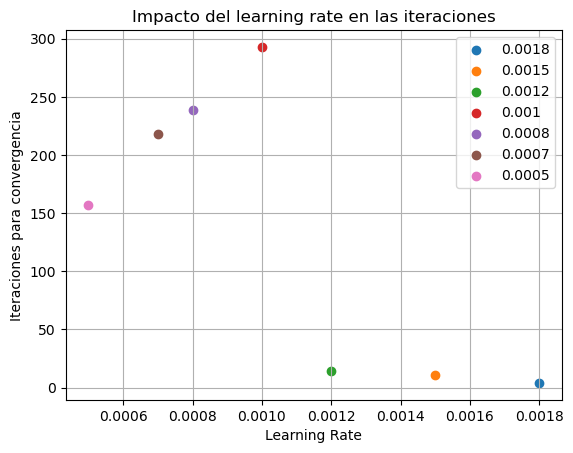

In [151]:
for i in range(len(alphas)):
    alfa = alphas[i]
    plt.scatter(alfa, len(errores_iteraciones_test[i]), label = alfa)
plt.xlabel('Learning Rate')
plt.ylabel('Iteraciones para convergencia')
plt.title('Impacto del learning rate en las iteraciones')
plt.grid()
plt.legend()
plt.show()

<h3>Ejercicio 5</h3>Fueron tomadas como escalas a considerar: 256, 128, 64 y 32. Los cambios de escala fueron realizados de manera manual, no se ven reflejados en el código.<br>
Con 256, se puede realizar el descenso por gradiente en un tiempo aceptable y los resultados dan bastante bien.  <br>
Optimización con tolerancia 0.0001 y alpha 0.001 (alpha que da el menor error cuadrático para los datos de training). Realizado con ejecución de descenso por gradiente que se encuentra en el ejercicio 2, cambiando las escalas. <br>
<br>
Escala 512: en 17.2s, error 0.5 en 3 iteraciones
<br>
Escala 256: en 1min 35s, error 0.051 en 292 iteraciones
<br>
Escala 200: en 38.2s, error 0.065 en 188 iteraciones
<br>
Escala 128: en 1.4s, error 0.22 en 10 iteraciones
<br>
Escala 64: en 24.7s, error 0.11 en 429 iteraciones
<br>
Escala 32: en 17.4s, error 0.17 en 516 iteraciones

In [152]:
#Datos recolectados a partir de la experimentación con alfa 0.001
escalas = np.array([512, 256, 200, 128, 64, 32])
errores_promedio_convergencia = np.array([0.5, 0.051, 0.065, 0.22, 0.11, 0.17]) #error minimo alcanzado
tiempos_convergencia = np.array([17.2, 95,38.2,1.4,24.7,17.4]) #tiempos de ejecucion en segundos
iteraciones_convergencia = np.array([3, 292,188,10,429,516])

tiempo_iteracion = tiempos_convergencia/iteraciones_convergencia
np.round(tiempo_iteracion, 2)

array([5.73, 0.33, 0.2 , 0.14, 0.06, 0.03])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


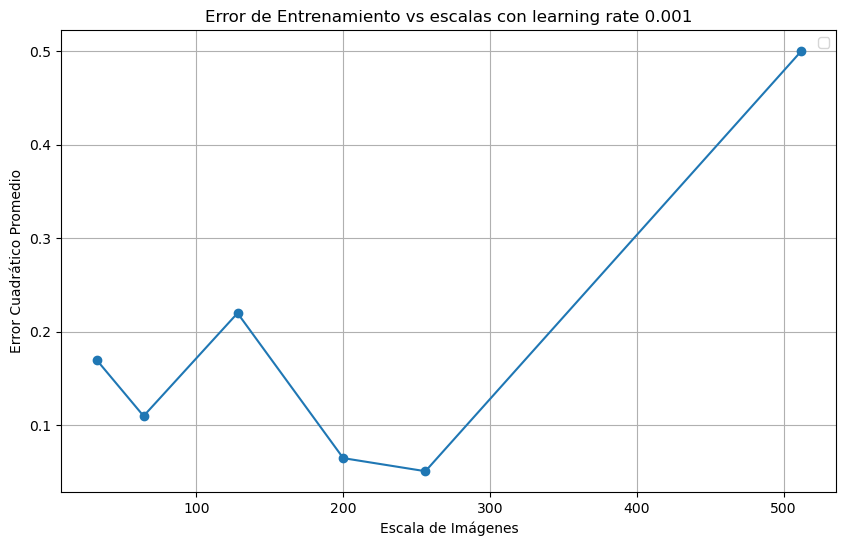

In [153]:
plt.figure(figsize=(10, 6))
plt.plot(escalas, errores_promedio_convergencia, marker='o')
plt.xlabel('Escala de Imágenes')
plt.ylabel('Error Cuadrático Promedio')
plt.title('Error de Entrenamiento vs escalas con learning rate 0.001')
plt.grid(True)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


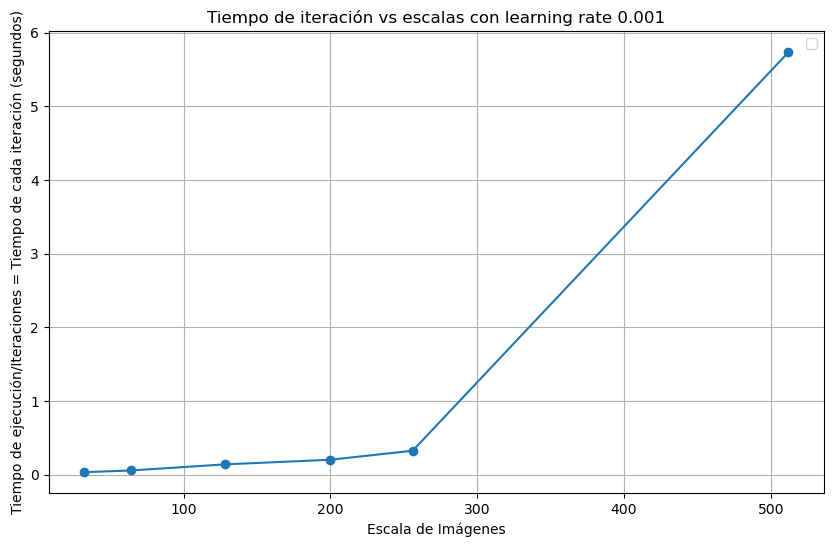

In [154]:
plt.figure(figsize=(10, 6))
plt.plot(escalas, tiempo_iteracion, marker='o')
plt.xlabel('Escala de Imágenes')
plt.ylabel('Tiempo de ejecución/Iteraciones = Tiempo de cada iteración (segundos)')
plt.title('Tiempo de iteración vs escalas con learning rate 0.001')
plt.grid(True)
plt.legend()
plt.show()

<h3>Ejercicio 6</h3>

In [166]:
y_true = []
y_pred = []

#valores de y_true -> verdadero diagnóstico
for i in range(len(x_test_sanos)):
    y_true.append(0)
for i in range(len(x_test_neum)):
    y_true.append(1)

#valores de y_pred -> diagnóstico predicho por el modelo
for i in range(len(x_test_sanos)):
    y_pred.append(np.round(f(x_test_sanos[i],w,b)))
for i in range(len(x_test_neum)):
    y_pred.append(np.round(f(x_test_neum[i],w,b)))


cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

divisores = np.array([len(x_test_sanos), len(x_test_neum)])

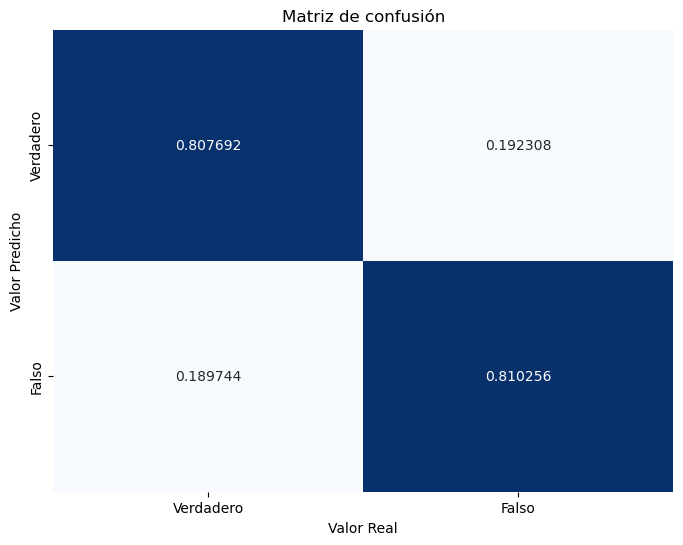

In [167]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='2f', cmap='Blues', cbar=False,
            xticklabels=['Verdadero', 'Falso'],
            yticklabels=['Verdadero', 'Falso'])

plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')
plt.title('Matriz de confusión')
plt.show()